In [75]:
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_score, average_precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling1D, MaxPooling2D, LeakyReLU
from keras.initializers import RandomNormal
import keras.optimizers as opt
from keras.callbacks import TensorBoard, History, EarlyStopping
from keras.utils import plot_model
from keras.regularizers import l2

In [5]:
CHANNELS = np.array(['A1-RF', 'A2-RF', 'C3-RF', 'C4-RF', 'Cz-RF', 'F3-RF',
                     'F4-RF', 'F7-RF', 'F8-RF', 'Fp1-RF', 'Fp2-RF', 'Fz-RF',
                     'O1-RF', 'O2-RF', 'P3-RF', 'P4-RF', 'Pz-RF', 'T3-RF',
                     'T4-RF', 'T5-RF', 'T6-RF'])

In [209]:
data = np.load('data/data.npy')
peak = np.load('data/peak.npy')
print(f'data = {data.shape}')
print(f'peak = {peak.shape}')

data = (83540, 21, 77)
peak = (83540, 77)


In [229]:
X = np.copy(data)
Y = np.copy(peak)

In [230]:
def draw_peaks(data, channels = CHANNELS, peaks = None):
    d, n = data.shape
    x = list(range(n))

    plt.rcParams['figure.figsize'] = (17, 17)
    peaks = np.where(peaks == 1)[0] if peaks is not None else None
    
    for i in range(d):
        ax = plt.subplot(d, 1, i + 1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i < d - 1:
            ax.spines['bottom'].set_visible(False)
        ax.plot(x, data[i])
        plt.ylabel(channels[i])
        plt.xlim((0,n))
        if peaks is not None:
            for xl in peaks:
                ax.axvline(x = xl, color='r', linestyle='--', linewidth = 1.)
    plt.show()

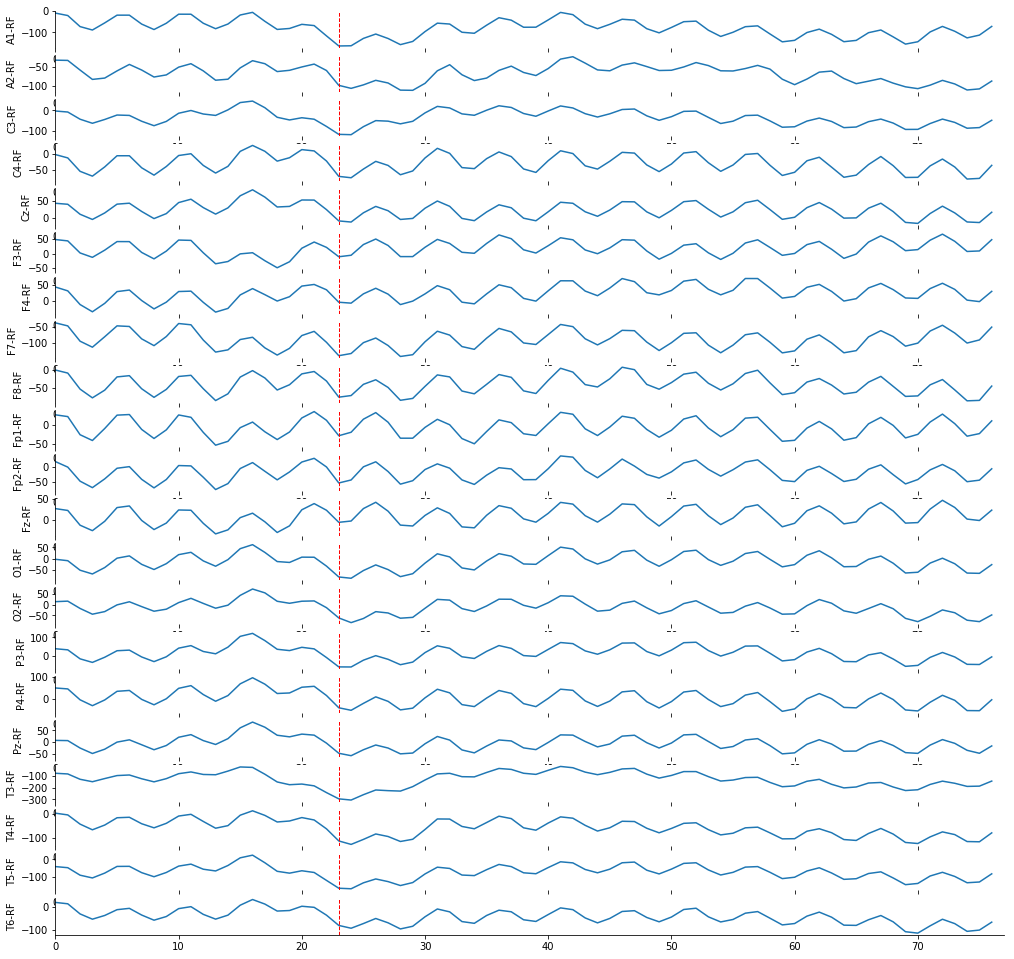

In [231]:
slide = 1
draw_peaks(X[slide,:,:], peaks = Y[slide,:])

In [232]:
shape = X.shape
std = StandardScaler().fit(X.reshape(-1,1))
X = std.transform(X.reshape(-1,1)).reshape(shape)

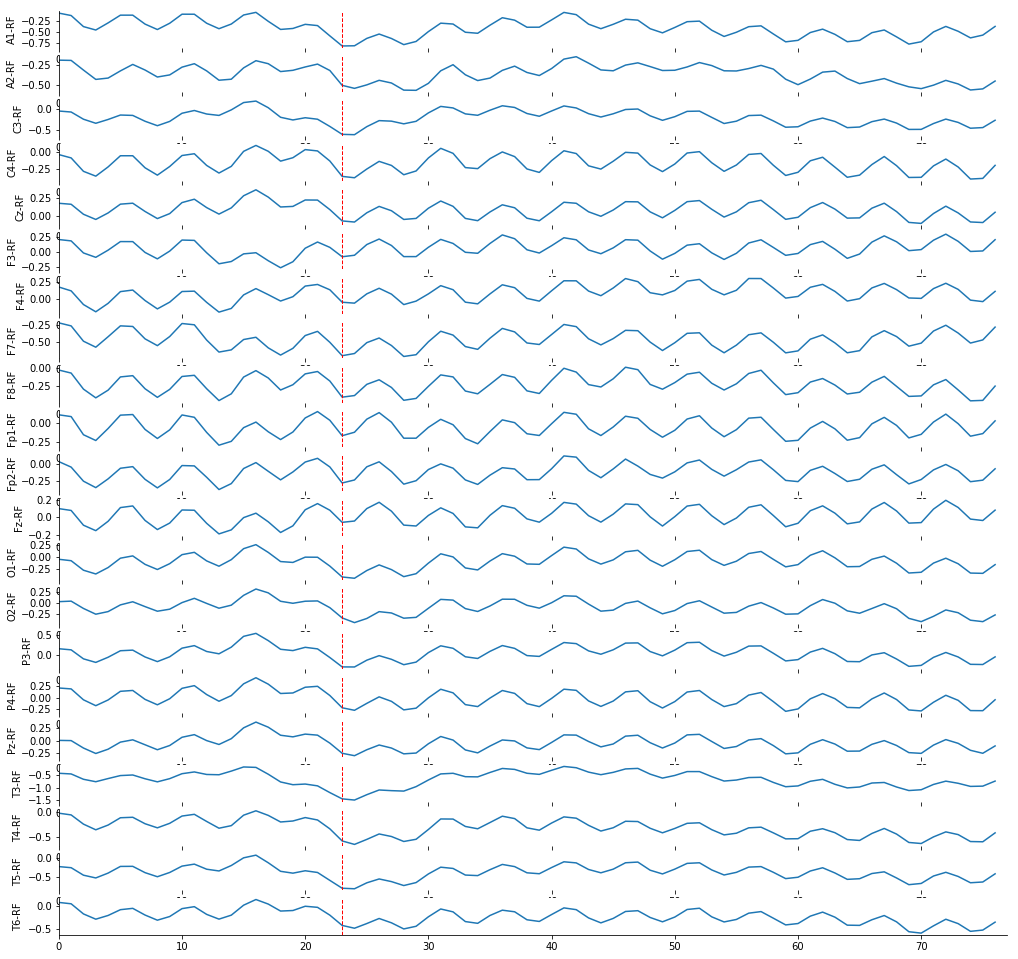

In [233]:
draw_peaks(X[slide,:,:], peaks = Y[slide,:])

In [234]:
I = np.array(range(len(X)))
X,Y,I = shuffle(X,Y,I)

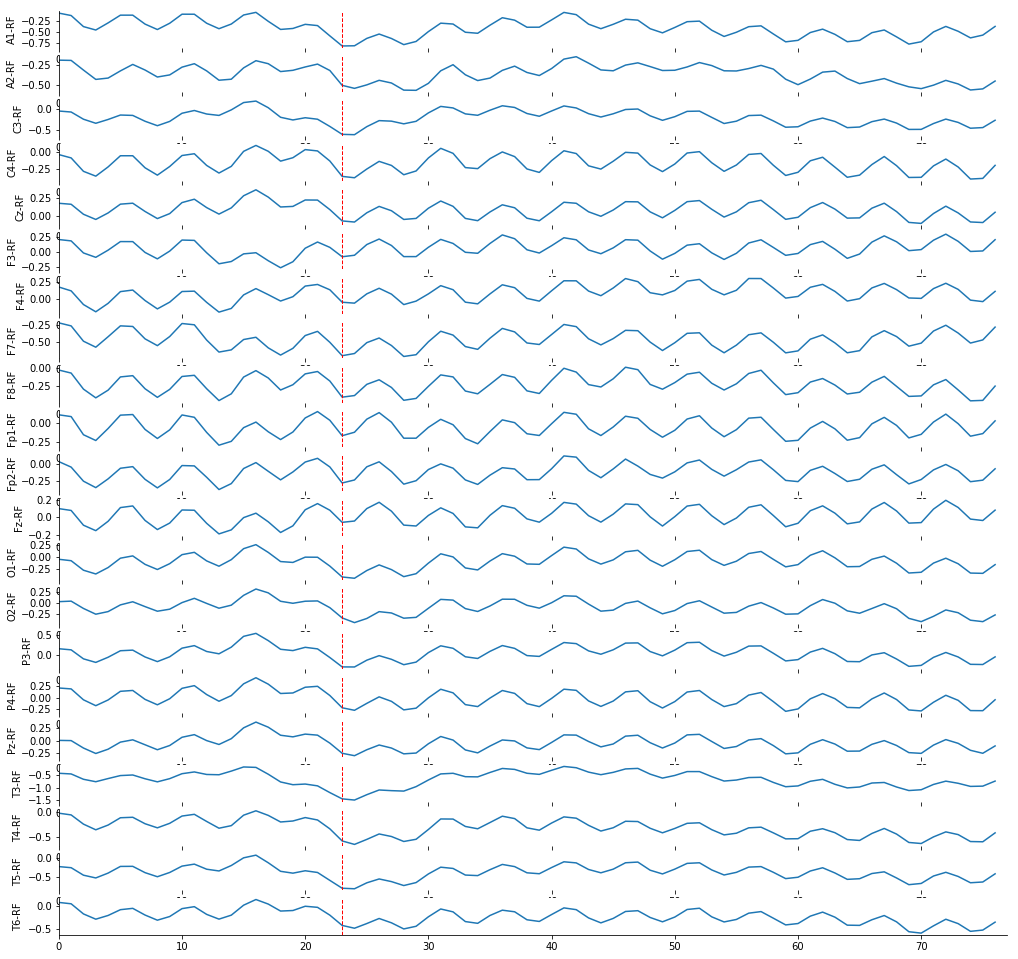

In [235]:
slide_new = np.where(I == slide)[0][0]
draw_peaks(X[slide_new,:,:], peaks = Y[slide_new,:])

In [236]:
s = X.shape
X = np.reshape(X, (s[0], s[1] * s[2]))

In [237]:
x_train, x_test,  y_train, y_test  = train_test_split(X, Y, test_size = 0.2, random_state = 31)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.25, random_state = 31)

In [238]:
print(f"train: x={x_train.shape} y={y_train.shape}")
print(f"valid: x={x_valid.shape} y={y_valid.shape}")
print(f"test : x={x_test.shape}  y={y_test.shape}")

train: x=(50124, 1617) y=(50124, 77)
valid: x=(16708, 1617) y=(16708, 77)
test : x=(16708, 1617)  y=(16708, 77)


In [242]:
cnn_input = X.shape[1]
cnn_output = Y.shape[1]
batch_size = 32

print(f"cnn_input  = {cnn_input}")
print(f"cnn_output = {cnn_output}")
print(f"batch_size = {batch_size}")

cnn_input  = 1617
cnn_output = 77
batch_size = 32


In [269]:
model = Sequential()

model.add(Dense(cnn_input, input_dim = cnn_input, activation = 'tanh', name = 'input'))
# model.add(Dense(cnn_input * 2, activation = 'tanh', name = 'dense1'))
# model.add(Dense(cnn_input * 2, activation = 'tanh', name = 'dense2'))
# model.add(Dense(cnn_input * 2, activation = 'tanh', name = 'dense3'))
model.add(Dense(cnn_output, activation='sigmoid', name='output'))

# model.add(Conv2D(16, (7,7), activation = 'tanh', name = 'conv1', input_shape = cnn_input, 
#                  kernel_regularizer=l2(0.005)))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), name='maxpool1'))

# model.add(Conv2D(32, (5,5), activation='tanh', name='conv2'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), name='maxpool2'))

# model.add(Conv2D(64, (3,3), activation='tanh', name='conv3'))
# model.add(MaxPooling2D(pool_size=(2,2), name='maxpool3'))

# model.add(Flatten(name='flat4'))
##model.add(Dropout(0.5, name='drop4'))

# model.add(Dense(1024, activation='tanh', name='dense4'))

# model.add(Dense(cnn_output, activation='sigmoid', name='output'))

In [270]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 1617)              2616306   
_________________________________________________________________
output (Dense)               (None, 77)                124586    
Total params: 2,740,892
Trainable params: 2,740,892
Non-trainable params: 0
_________________________________________________________________


In [271]:
import keras.backend as kb

def custom_loss(y_true, y_pred):
    return kb.sum(kb.abs(y_pred - y_true))

def diff(y_true, y_pred):
    return kb.sum(kb.abs(kb.round(y_pred) - y_true))

In [272]:
optim = opt.SGD(lr = 0.001, decay = 1e-6, momentum = 0.5, nesterov=True)
model.compile(optimizer=optim, loss=custom_loss, metrics=[diff])

In [273]:
est = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
log = model.fit(x_train, y_train, batch_size = batch_size, epochs = 100,
          verbose = 2, validation_data=(x_valid, y_valid), callbacks = [est])

Train on 50124 samples, validate on 16708 samples
Epoch 1/100
 - 7s - loss: 113.5867 - diff: 80.6237 - val_loss: 14.1061 - val_diff: 0.6148
Epoch 2/100
 - 5s - loss: 11.9995 - diff: 1.9868 - val_loss: 4.8600 - val_diff: 0.5209
Epoch 3/100
 - 6s - loss: 5.1325 - diff: 0.5854 - val_loss: 3.2378 - val_diff: 0.5190
Epoch 4/100
 - 5s - loss: 2.6307 - diff: 0.5337 - val_loss: 2.6735 - val_diff: 0.5229
Epoch 5/100
 - 5s - loss: 2.8529 - diff: 0.5388 - val_loss: 1.8132 - val_diff: 0.5190
Epoch 6/100
 - 5s - loss: 1.7031 - diff: 0.4654 - val_loss: 1.2449 - val_diff: 0.5190
Epoch 7/100
 - 5s - loss: 1.3385 - diff: 0.4695 - val_loss: 1.3827 - val_diff: 0.5248
Epoch 8/100
 - 5s - loss: 1.3648 - diff: 0.4743 - val_loss: 1.2862 - val_diff: 0.5190
Epoch 9/100
 - 4s - loss: 1.1484 - diff: 0.4656 - val_loss: 1.8344 - val_diff: 0.5190
Epoch 10/100
 - 4s - loss: 1.1946 - diff: 0.4846 - val_loss: 2.0442 - val_diff: 0.5190
Epoch 11/100
 - 4s - loss: 1.1044 - diff: 0.4865 - val_loss: 1.1090 - val_diff: 0.51

In [274]:
result = model.evaluate(x_test, y_test)
print('Testing:')
print('\n'.join('{} = {}'.format(*k) for k in zip(model.metrics_names, result)))

16708/16708 [==============================] - 0s 27us/step
Testing:
loss = 0.658820083716172
diff = 0.5362700502753173


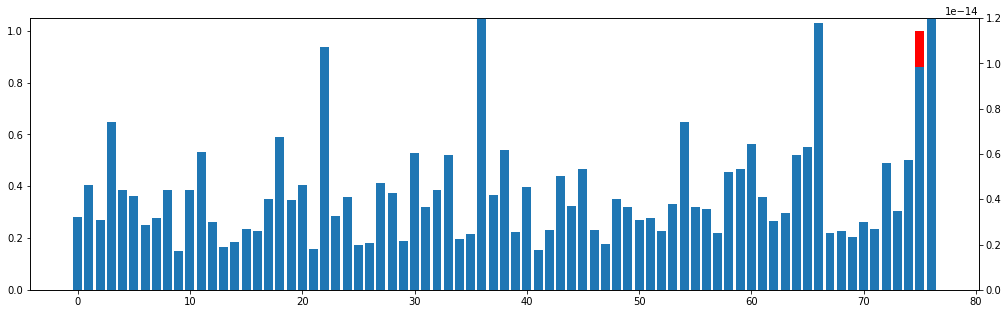

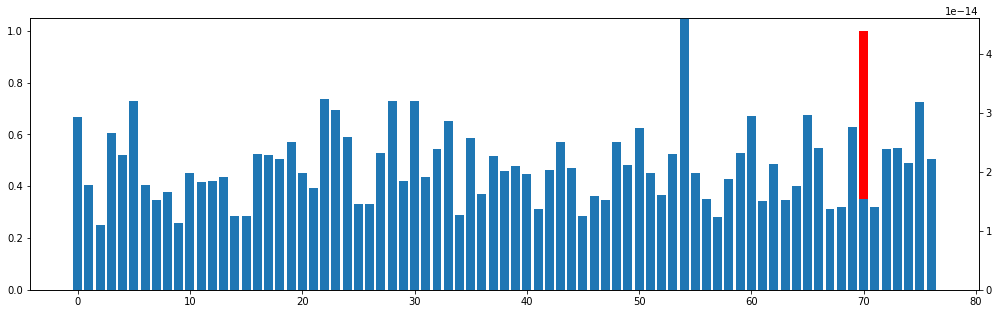

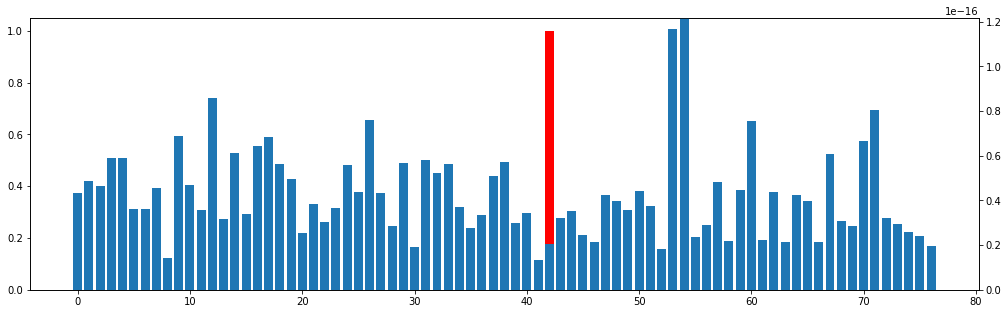

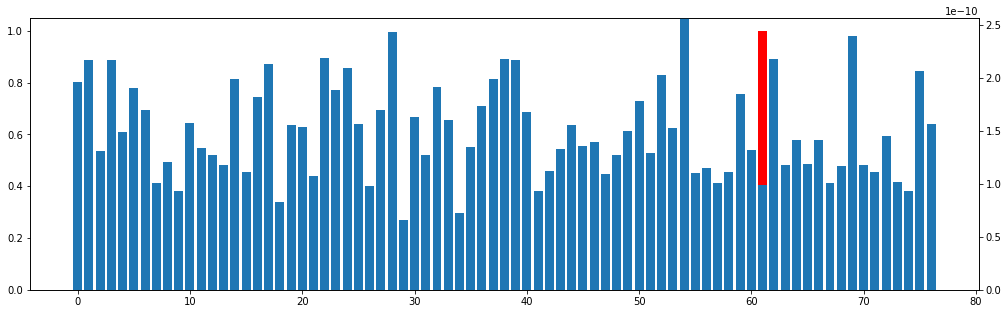

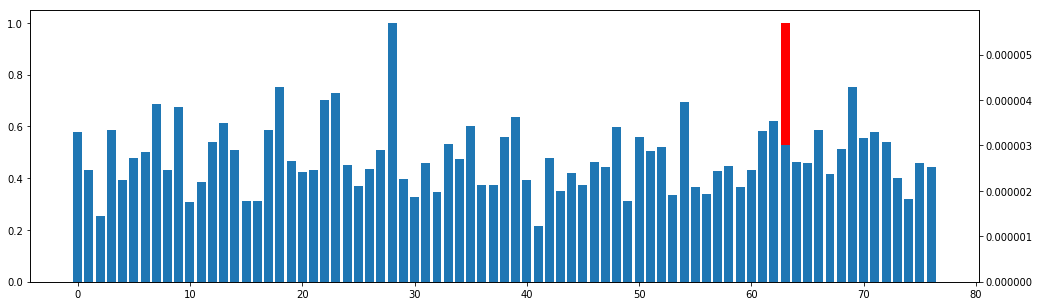

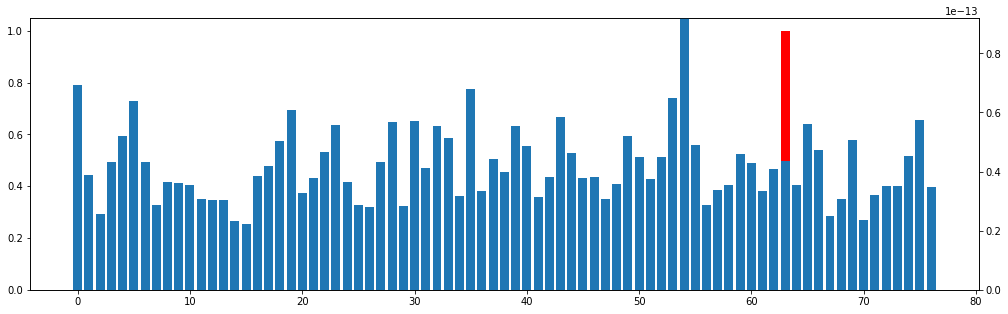

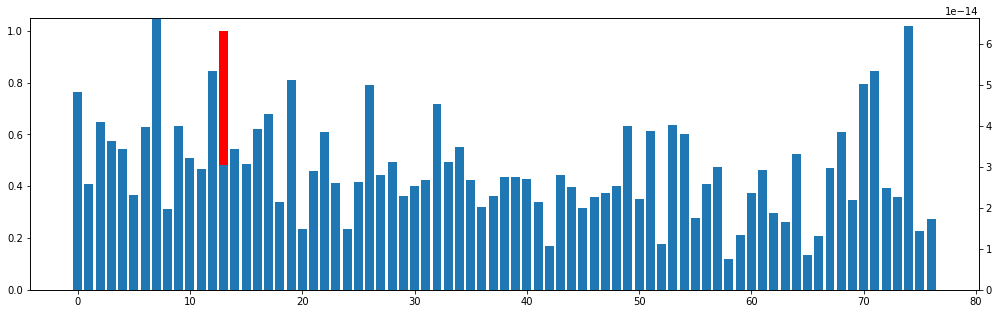

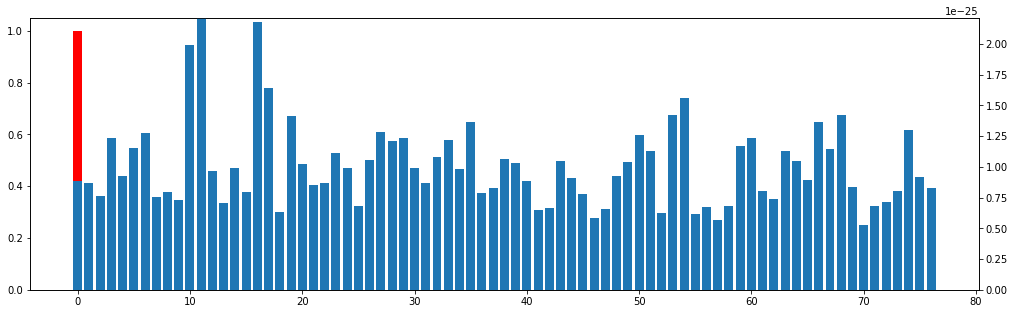

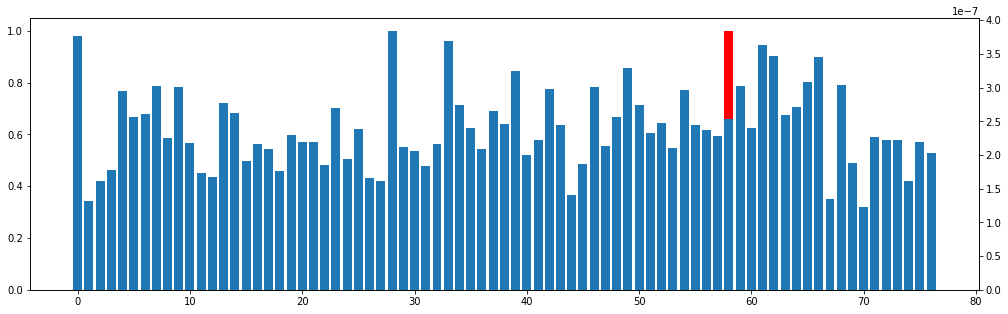

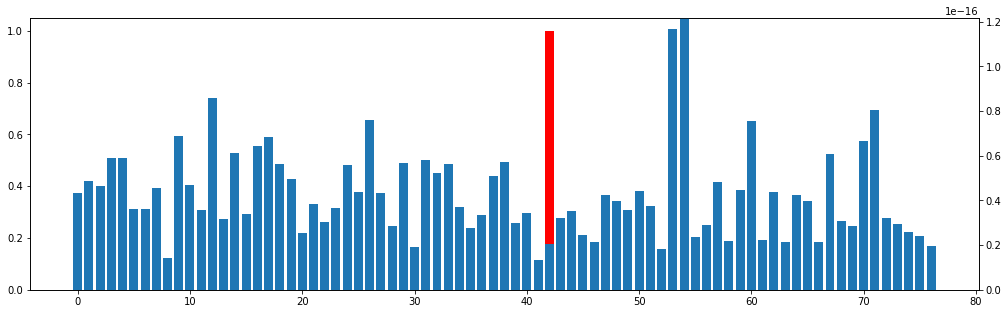

In [275]:
y_pred = model.predict(x_test)
plt.rcParams['figure.figsize'] = (17, 5)
for i in np.where(np.sum(y_test, axis=1) > 0)[0][:10]:
    plt.close()
    plt.bar(range(77), y_test[i], color = 'r')
    ax2 = plt.twinx()
    ax2.bar(range(77), y_pred[i])
    plt.show()

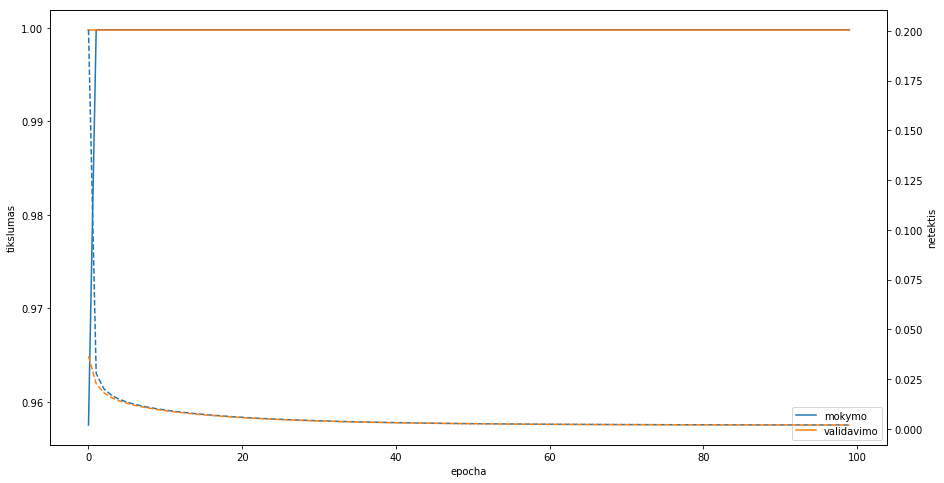

In [166]:
plt.rcParams['figure.figsize'] = (15, 8)

plt.plot(log.history['acc'], label = 'mokymo')
plt.plot(log.history['val_acc'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend() #['mokymo', 'testavimo'])

ax2 = plt.twinx()
ax2.plot(log.history['loss'], '--', label = 'mokymo')
ax2.plot(log.history['val_loss'], '--', label = 'validavimo')
ax2.set_ylabel('netektis')
#plt.title('model accuracy')
plt.show()

#joblib.dump(model, os.path.join(OUTPUT_FOLDER,f'nn_{h}_veg.pkl'))

In [ ]:
confusion_matrix(y_test, model.predict_classes(x_test))

In [ ]:
f1_score(y_test, model.predict_classes(x_test))

In [ ]:
roc_auc_score(y_test, model.predict(x_test))

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
roc = roc_curve(y_test, model.predict(x_test))
plt.plot(roc[0],roc[1])
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
prc = precision_recall_curve(y_test, model.predict(x_test))
plt.plot(prc[0],prc[1])
plt.show()

In [90]:
average_precision_score(y_test, model.predict(x_test))

0.9706534586842358

In [93]:
precision_score(y_test, model.predict_classes(x_test))

0.9473684210526315

In [94]:
recall_score(y_test, model.predict_classes(x_test))

0.8852459016393442